<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [ ]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Data From Test and train CSV both and splitting them later to decrease the processing steps


In [3]:
df = pd.read_csv('loan_train.csv')
df2=pd.read_csv('loan_test.csv')
df=df.append(df2,ignore_index=True)

/tmp/ipykernel_220508/1029719029.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2,ignore_index=True)


In [ ]:
df.shape

### Convert to date time object


In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [ ]:
df['loan_status'].value_counts()

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

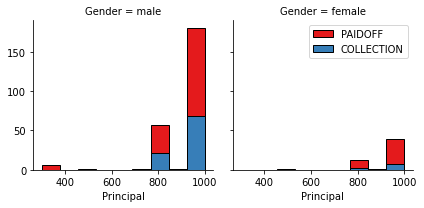

In [5]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

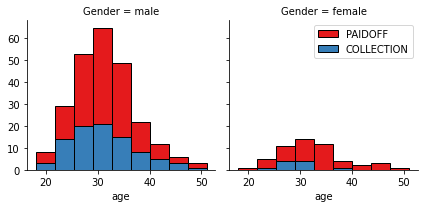

In [6]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


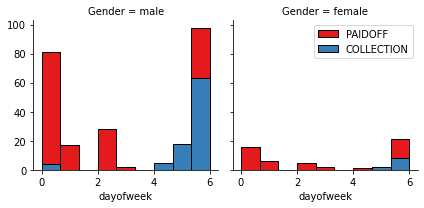

In [7]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [8]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.732938
        COLLECTION     0.267062
1       PAIDOFF        0.841270
        COLLECTION     0.158730
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [9]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [11]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.788462
                      COLLECTION     0.211538
High School or Below  PAIDOFF        0.715116
                      COLLECTION     0.284884
Master or Above       PAIDOFF        0.750000
                      COLLECTION     0.250000
college               PAIDOFF        0.773256
                      COLLECTION     0.226744
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [ ]:
df[['Principal','terms','age','Gender','education']].head()

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [12]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [13]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [14]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [15]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.50130175,  0.92089421,  2.31334964, -0.43236977, -1.21838912,
        -0.38655567,  1.15133896, -0.86855395],
       [ 0.50130175,  0.92089421,  0.32194392,  2.31283513, -1.21838912,
         2.5869495 , -0.86855395, -0.86855395],
       [ 0.50130175, -0.9332552 , -0.67375893, -0.43236977, -1.21838912,
        -0.38655567, -0.86855395,  1.15133896],
       [ 0.50130175,  0.92089421, -0.50780846,  2.31283513,  0.82075585,
        -0.38655567, -0.86855395,  1.15133896],
       [ 0.50130175,  0.92089421, -0.34185798, -0.43236977,  0.82075585,
        -0.38655567, -0.86855395,  1.15133896]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import plotly.express as px

In [67]:
acc=[]
k_size=[]
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
for i in range(1,25,1):
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(x_train,y_train)
    acc.append(clf.score(x_test,y_test))
    k_size.append(i)
px.line(x=k_size,y=acc,markers='*').update_layout(xaxis_title="Number of neighbors considered",yaxis_title="Accuracy",)


In [68]:
clf=KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train,y_train)
print('Prediction Score: ',clf.score(x_test,y_test),
      '\njaccard score:=',jaccard_score(y_true=y_test,y_pred=clf.predict(x_test),pos_label = "PAIDOFF"),
     '\nf1 score:=',f1_score(y_true=y_test,y_pred=clf.predict(x_test),pos_label = "PAIDOFF"))

Prediction Score:  0.7833333333333333 
jaccard score:= 0.7570093457943925 
f1 score:= 0.8617021276595744


# Decision Tree


In [21]:
from sklearn.tree import DecisionTreeClassifier


In [69]:
acc=[]
depth_size=[]
for i in range(1,25,1):
    clf_tree=DecisionTreeClassifier(max_depth=i)
    clf_tree.fit(x_train,y_train)
    acc.append(clf_tree.score(x_test,y_test))
    depth_size.append(i)
px.line(x=depth_size,y=acc,markers='*').update_layout(xaxis_title="Max Depth",yaxis_title="Accuracy",)



In [70]:
clf_tree=DecisionTreeClassifier(criterion='gini',max_depth=2)
clf_tree.fit(x_train,y_train)
print('Prediction Score for Decision Tree: ',clf_tree.score(x_test,y_test),
      '\njaccard score for Decision Tree:=',jaccard_score(y_true=y_test,y_pred=clf_tree.predict(x_test),pos_label = "PAIDOFF"),
     '\nf1 score for Decision Tree:=',f1_score(y_true=y_test,y_pred=clf_tree.predict(x_test),pos_label = "PAIDOFF"))

Prediction Score for Decision Tree:  0.775 
jaccard score for Decision Tree:= 0.775 
f1 score for Decision Tree:= 0.8732394366197184


# Support Vector Machine


In [71]:
from sklearn import svm
clf_svm = svm.SVC(kernel='rbf')
clf_svm.fit(x_train, y_train) 
print('Prediction Score for svm-svc: ',clf_svm.score(x_test,y_test),
      '\njaccard score for svm-svc:=',jaccard_score(y_true=y_test,y_pred=clf_svm.predict(x_test),pos_label = "PAIDOFF"),
     '\nf1 score for svm-svc:=',f1_score(y_true=y_test,y_pred=clf_svm.predict(x_test),pos_label = "PAIDOFF"))

Prediction Score for svm-svc:  0.7666666666666667 
jaccard score for svm-svc:= 0.7522123893805309 
f1 score for svm-svc:= 0.8585858585858587


# Logistic Regression


In [72]:
from sklearn.linear_model import LogisticRegression
clf_lr= LogisticRegression().fit(x_train,y_train)
print('Prediction Score for Logistic Regression: ',clf_lr.score(x_test,y_test),
      '\njaccard score for Logistic Regression:=',jaccard_score(y_true=y_test,y_pred=clf_lr.predict(x_test),pos_label = "PAIDOFF"),
     '\nf1 score for Logistic Regression:=',f1_score(y_true=y_test,y_pred=clf_lr.predict(x_test),pos_label = "PAIDOFF"),
     '\nLogistic Regression log loss:=',log_loss(y_true=y_test,y_pred=clf_lr.predict_proba(x_test)))

Prediction Score for Logistic Regression:  0.775 
jaccard score for Logistic Regression:= 0.7631578947368421 
f1 score for Logistic Regression:= 0.8656716417910448 
Logistic Regression log loss:= 0.400947688876726


# Model Evaluation using Test set


In [73]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation


In [75]:
print('Knn jaccard score:=',jaccard_score(y_true=y_test,y_pred=clf.predict(x_test),pos_label = "PAIDOFF"),
'\nDecision tree jaccard score:=',jaccard_score(y_true=y_test,y_pred=clf_tree.predict(x_test),pos_label = "PAIDOFF")
,'\nsvm-svc jaccard score:=',jaccard_score(y_true=y_test,y_pred=clf_svm.predict(x_test),pos_label = "PAIDOFF"),
'\nLogistic Regression jaccard score:=',jaccard_score(y_true=y_test,y_pred=clf_lr.predict(x_test),pos_label = "PAIDOFF"))

Knn jaccard score:= 0.7570093457943925 
Decision tree jaccard score:= 0.775 
svm-svc jaccard score:= 0.7522123893805309 
Logistic Regression jaccard score:= 0.7631578947368421


In [76]:
print('Knn f1 score:=',f1_score(y_true=y_test,y_pred=clf.predict(x_test),pos_label = "PAIDOFF"),
'\nDecision tree f1 score:=',f1_score(y_true=y_test,y_pred=clf_tree.predict(x_test),pos_label = "PAIDOFF")
,'\nsvm-svc f1 score:=',f1_score(y_true=y_test,y_pred=clf_svm.predict(x_test),pos_label = "PAIDOFF"),
'\nLogistic Regression f1 score:=',f1_score(y_true=y_test,y_pred=clf_lr.predict(x_test),pos_label = "PAIDOFF"))

Knn f1 score:= 0.8617021276595744 
Decision tree f1 score:= 0.8732394366197184 
svm-svc f1 score:= 0.8585858585858587 
Logistic Regression f1 score:= 0.8656716417910448


In [77]:
print('Logistic Regression log loss:=',log_loss(y_true=y_test,y_pred=clf_lr.predict_proba(x_test)))

Logistic Regression log loss:= 0.400947688876726


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.757009| 0.861702 | NA      |
| Decision Tree      | 0.775   | 0.873239 | NA      |
| SVM                | 0.752212| 0.858585 | NA      |
| LogisticRegression | 0.763157| 0.865671 | 0.400947|


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
